# BIRDS

This is a small project utilizing the transformer architecture to generate new bird common names.

In [1]:
import csv
from matplotlib import pyplot as plt
# import numpy as np
# import pandas as pd

with open('birds.csv', newline='') as f:
    reader = csv.reader(f)
    data = [n for _,n in list(reader)[1:]]

data_lower = list(map(str.lower, data))

chars = set()
for s in data_lower:
    chars = chars.union(s)
chars = sorted(list(chars))
chars_to_drop = set(list(chars[30:]) + ['.'])
data = list(filter(lambda n: not chars_to_drop.intersection(n), data_lower))

chars = ['#'] + list(sorted(set(chars).difference(chars_to_drop)))
vocab_size = len(chars)

ch2i = { ch:i for i,ch in enumerate(chars)}
i2ch = { i:ch for i,ch in enumerate(chars)}

print(f'{len(data)=}, {vocab_size=}')

len(data)=10817, vocab_size=30


In [2]:
import torch
from torch import nn
import torch.nn.functional as F

if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


# MLP

In [3]:
block_size = 20
emd_dim = 8
hidden_dim = 400

In [4]:
def build_dataset(data):
    xs, ys = [], []

    for name in data:
        chrs = ['#']*block_size + list(name) + ['#']
        for ix in range(len(chrs)-block_size):
            xs.append([ch2i[ch] for ch in chrs[ix:ix+block_size]])
            ys.append(ch2i[chrs[ix+block_size]])

    X = torch.tensor(xs)
    Y = torch.tensor(ys)

    return X, Y

In [5]:
import random
random.seed(0)
random.shuffle(data)

n1 = int(len(data)*0.9)
n2 = int(len(data)*0.95)

X_train, Y_train = build_dataset(data[:n1])
X_valid, Y_valid = build_dataset(data[n1:n2])
X_test, Y_test = build_dataset(data[n2:])

X_total = torch.cat([X_train, X_valid, X_test])
Y_total = torch.cat([Y_train, Y_valid, Y_test])

In [6]:
n1, n2, len(data), len(X_train), len(X_valid), len(X_test)

(9735, 10276, 10817, 191515, 10650, 10624)

In [7]:
g = torch.Generator().manual_seed(42)

C = torch.randn((vocab_size, emd_dim), generator=g)
# W1 = nn.init.kaiming_normal_(torch.empty((block_size*emd_dim, hidden_dim)), mode='fan_in', nonlinearity='tanh')
W1 = torch.randn((block_size*emd_dim, hidden_dim), generator=g) * 0.01
# b1 = torch.randn((hidden_dim,), generator=g) * 0.01
# W2 = nn.init.kaiming_normal_(torch.empty((hidden_dim, vocab_size)), mode='fan_in', nonlinearity='tanh')
W2 = torch.randn((hidden_dim, vocab_size), generator=g) * 0.01
b2 = torch.randn((vocab_size,), generator=g) * 0.01

bngain = torch.ones((1, hidden_dim))
bnbias = torch.zeros((1, hidden_dim))
bnstd_running = torch.ones((1, hidden_dim))
bnmean_running = torch.zeros((1, hidden_dim))

parameters = [C, W1, W2, b2]

for p in parameters:
    p.requires_grad_(True)

In [8]:
emb = C[X_test] # (batch_size, block_size, emd_dim)
h = torch.tanh(emb.view(-1, block_size*emd_dim) @ W1 ) # (batch_size, hidden_dim)
logits = h @ W2 + b2 # (batch_size, vocab_size)
out = F.softmax(logits, dim=1) # (batch_size, vocab_size)

C.std(), W1.std(), h.std(), W2.std(), logits.std(), out.std()

(tensor(1.0045, grad_fn=<StdBackward0>),
 tensor(0.0101, grad_fn=<StdBackward0>),
 tensor(0.1557, grad_fn=<StdBackward0>),
 tensor(0.0101, grad_fn=<StdBackward0>),
 tensor(0.0321, grad_fn=<StdBackward0>),
 tensor(0.0011, grad_fn=<StdBackward0>))

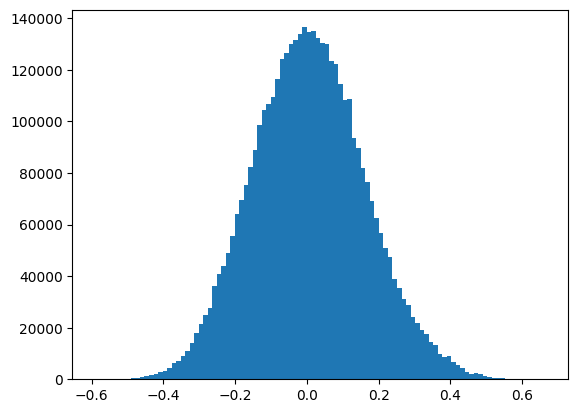

In [9]:
plt.figure()
plt.hist(h.view(-1).detach().numpy(), bins=100);
plt.show()

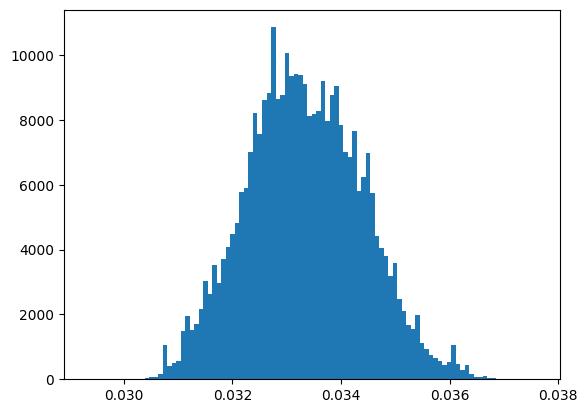

In [10]:
plt.figure()
plt.hist(out.view(-1).detach().numpy(), bins=100);
plt.show()

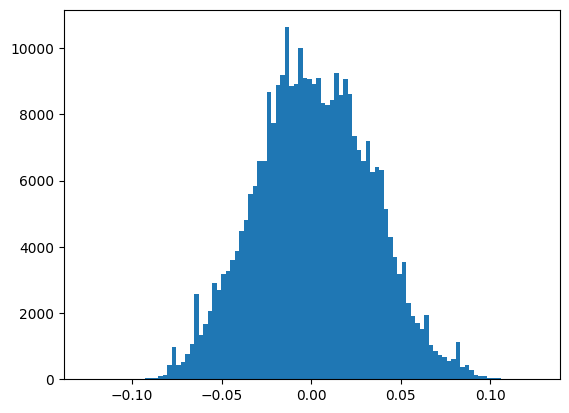

In [11]:
plt.figure()
plt.hist(logits.view(-1).detach().numpy(), bins=100);
plt.show()

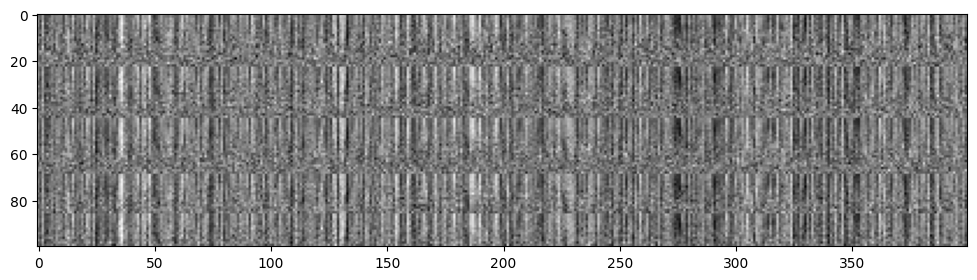

In [12]:
plt.figure(figsize=(12,12))
plt.imshow(h[:100].detach().numpy(), cmap='gray');

In [13]:
print(f'number of params: {sum(p.numel() for p in parameters)}')

number of params: 76270


In [14]:
steps = 1000
batch_size = 32
lre = torch.linspace(-2, 1, steps)
lrs = 10**lre

In [15]:
X = X_train
Y = Y_train

In [16]:
# lossi = []


# for i in range(steps):

#     # minibatch
#     ixs = torch.randint(0, X.size()[0], (batch_size,))

#     # forward pass
#     emb = C[X[ixs]] # (batch_size, block_size, emd_dim)
#     h = torch.tanh(emb.view(-1, block_size*emd_dim) @ W1 + b1) # (batch_size, hidden_dim)
#     logits = h @ W2 + b2 # (batch_size, vocab_size)
#     loss = F.cross_entropy(logits, Y[ixs])
#     lossi.append(loss.item())

#     # backward pass
#     for p in parameters:
#         p.grad = None
#     loss.backward()
#     # update
#     for p in parameters:
#         p.data -= lrs[i] * p.grad

#     if i % (steps//10) == 0:
#         print(f'{i=}, {lossi[i]=}')


# emb = C[X] # (batch_size, block_size, emd_dim)
# h = torch.tanh(emb.view(-1, block_size*emd_dim) @ W1 + b1) # (batch_size, hidden_dim)
# logits = h @ W2 + b2 # (batch_size, vocab_size)
# loss = F.cross_entropy(logits, Y)
# print(f'{loss.item()=}')

In [17]:
# from matplotlib import pyplot as plt

# plt.plot(lre, lossi)

In [18]:
steps = 200000
lr = .1

In [19]:
loss_unif = -torch.tensor(1/vocab_size).log()
print(f'Expected loss at initialization: {loss_unif.item():.4f}')

Expected loss at initialization: 3.4012


In [20]:
lossi = []
loglossi = []

for i in range(steps):

    if (i%(steps//2)) == 0 and i > 0:
        lr /= 10

    # minibatch
    ixs = torch.randint(0, X.size()[0], (batch_size,))

    # forward pass
    emb = C[X[ixs]] # (batch_size, block_size, emd_dim)
    embview = emb.view(-1, block_size*emd_dim) # (batch_size, block_size*emd_dim)
    harg = embview @ W1 # (batch_size, hidden_dim)

    # batch norm
    bnstdi = harg.std(dim=0, keepdim=True)
    bnmeani = harg.mean(dim=0, keepdim=True)
    harg = bngain * (harg - bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani

    h = torch.tanh(harg) # (batch_size, hidden_dim)
    logits = h @ W2 + b2 # (batch_size, vocab_size)
    loss = F.cross_entropy(logits, Y[ixs])

    lossi.append(loss.item())
    loglossi.append(loss.log10().item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data -= lr * p.grad

    if i % (steps//10) == 0:
        print(f'{i=}, {lossi[i]=}')

i=0, lossi[i]=3.3917970657348633
i=20000, lossi[i]=1.2098280191421509
i=40000, lossi[i]=1.1480417251586914
i=60000, lossi[i]=0.7908530831336975
i=80000, lossi[i]=1.5839765071868896
i=100000, lossi[i]=1.232393503189087
i=120000, lossi[i]=0.6436711549758911
i=140000, lossi[i]=0.79400235414505
i=160000, lossi[i]=0.7929431200027466
i=180000, lossi[i]=1.0784293413162231


In [21]:
# print(bnstd_running, bnmean_running)

In [22]:
# # Calibrate batchnorm

# emb = C[X_train] # (batch_size, block_size, emd_dim)
# embview = emb.view(-1, block_size*emd_dim) # (batch_size, block_size*emd_dim)
# harg = embview @ W1  # (batch_size, hidden_dim)

# bngain = harg.std(dim=0, keepdim=True)
# bnbias = harg.mean(dim=0, keepdim=True)

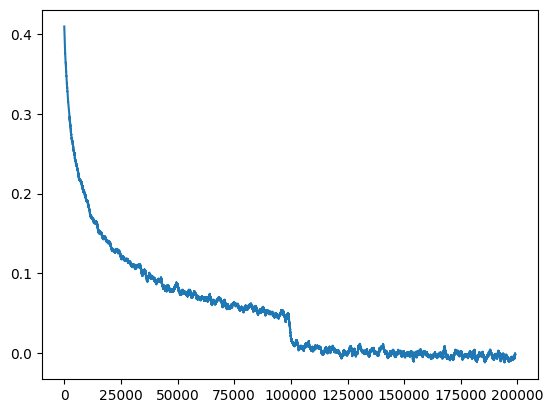

In [23]:
roll = 1000
rolling_loss = [sum(loglossi[i:i+roll])/roll for i in range(len(lossi)-roll)]

fig = plt.figure()
plt.plot(rolling_loss)

In [30]:
def compute_loss(X, Y):
    emb = C[X] # (batch_size, block_size, emd_dim)
    embview = emb.view(-1, block_size*emd_dim) # (batch_size, block_size*emd_dim)
    harg = embview @ W1 # (batch_size, hidden_dim)

    # batch norm
    harg = bngain * (harg - bnmean_running) / bnstd_running + bnbias

    h = torch.tanh(harg) # (batch_size, hidden_dim)
    logits = h @ W2 + b2 # (batch_size, vocab_size)
    loss = F.cross_entropy(logits, Y)
    print(f'{loss.item()=}')

compute_loss(X_train, Y_train)
compute_loss(X_valid, Y_valid)

loss.item()=0.9360036253929138
loss.item()=1.1377851963043213


In [31]:
temperature = 1

In [34]:
# g = torch.Generator().manual_seed(0)
for _ in range(20):
    context = [ch2i['#']] * block_size
    while True:
        # forward pass
        Xc = torch.tensor(context).unsqueeze(0)
        emb = C[Xc] # (batch_size, block_size, emd_dim)
        embview = emb.view(-1, block_size*emd_dim) # (batch_size, block_size*emd_dim)
        harg = embview @ W1 # (batch_size, hidden_dim)

        # batch norm
        harg = bngain * (harg - bnmean_running) / bnstd_running + bnbias

        h = torch.tanh(harg) # (batch_size, hidden_dim)
        logits = h @ W2 + b2 # (batch_size, vocab_size)
        logits = logits / temperature
        probs = F.softmax(logits, dim=1)

        next_ch = torch.multinomial(probs, 1, generator=g).item()
        context = context[1:] + [next_ch]
        if next_ch == ch2i['#']:
            print()
            break
        print(i2ch[next_ch], end='')

slaty plumbul
white-bellied parrot
furcduam's strikent
blue-eared bristleon
wamarcater chackcree
andian franz pyziren
white-bellied sparrow
black-eared frontolia
pink heron
yellow-lented worbler
dusky mynospipit'a
swarlet-rumped tody flycatcher
monctacled redey-heera
white-crowned finch
white-bearded helsonch
buff-breasted wood quail
spot-throated leafird
aured owlancs
bury-bellied woodpecker
white-throated woodcreeper


In [33]:
# %matplotlib widget 
# fig = plt.figure(figsize=(12, 12))
# ax = fig.add_subplot(projection='3d')
# ax.scatter(C[:,0].data, C[:,1].data, C[:,2].data, s=300)
# for i, txt in enumerate(chars):
#     ax.text(C[i,0].item(), C[i,1].item(), C[i,2].item(), txt, ha='center', va='center', fontsize=15)

# plt.grid()

In [ ]:
# for i in range(5000):

#     # minibatch
#     ixs = torch.randint(0, X.size()[0], (batch_size,))

#     # forward pass
#     emb = C[X[ixs]] # (batch_size, block_size, emd_dim)
#     h = torch.tanh(emb.view(-1, block_size*emd_dim) @ W1 + b1) # (batch_size, hidden_dim)
#     logits = h @ W2 + b2 # (batch_size, vocab_size)
#     counts = logits.exp()
#     probs = counts / counts.sum(dim=1, keepdim=True)
#     loss = -probs[torch.arange(batch_size), Y[ixs]].log().mean()

#     # backward pass
#     dlogits = torch.zeros_like(logits)
#     dlogits[torch.arange(batch_size), Y[ixs]] = 1
#     dlogits = (probs - dlogits) / batch_size
#     dW2 = h.t() @ dlogits
#     db2 = dlogits.sum(dim=0)
#     dh = dlogits @ W2.t()
#     dargth = (1 - h*h) * dh
#     demb = dargth @ W1.t()
#     dW1 = (emb.view(-1, block_size*emd_dim)).t() @ dargth
#     db1 = dargth.sum(dim=0)
#     dC = torch.zeros_like(C)
#     dC.index_add_(0, X[ixs].view(-1), demb.view(-1, emd_dim))
#     # update
#     W1 = W1 - lr * dW1
#     b1 = b1 - lr * db1
#     W2 = W2 - lr * dW2
#     b2 = b2 - lr * db2
#     C = C - lr * dC

#     if i % 500 == 0:
#         print(f'{i=}, {loss.item()=}')